Okay, now that we're done with the data wrangling, let's start doing some analysis/mapping of the charger/sales data and how they relate to each other!

In [1]:
import pandas as pd
import geopandas as gpd

In [4]:
df = pd.read_pickle('data/q2')
df.head(10)

,Number of Vehicles,chargers,geometry,Chargers/EV,EVs/Charger
ZIP,,,,,
90001,168,1.0,"POLYGON ((-118.26519 33.98923, -118.25644 33.9...",5.952381,168.000000
90002,126,6.0,"POLYGON ((-118.26512 33.96013, -118.25858 33.9...",47.619048,21.000000
90003,124,5.0,"POLYGON ((-118.28320 33.98914, -118.28039 33.9...",40.322581,24.800000
90004,1576,3.0,"POLYGON ((-118.33858 34.08346, -118.33096 34.0...",1.903553,525.333333
90005,687,5.0,"MULTIPOLYGON (((-118.29291 34.06360, -118.2916...",7.278020,137.400000
90006,435,4.0,"POLYGON ((-118.30903 34.04719, -118.30904 34.0...",9.195402,108.750000
90007,248,66.0,"POLYGON ((-118.30149 34.03089, -118.30024 34.0...",266.129032,3.757576
90008,645,5.0,"POLYGON ((-118.37408 34.01485, -118.37263 34.0...",7.751938,129.000000
90009,6,0.0,None,0.000000,NaN


First, a quick check:

<AxesSubplot:xlabel='Number of Vehicles', ylabel='chargers'>

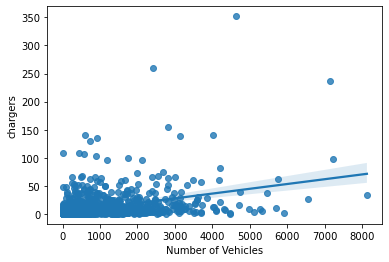

In [27]:
import seaborn as sns

sns.regplot(data = df, x = "Number of Vehicles", y = 'chargers')

Okay, so there is a positive correlation between chargers and sales, which makes sense, but there are also some pretty massive outliers. 

Now let's start by just mapping the distribution of chargers and sales statewide:

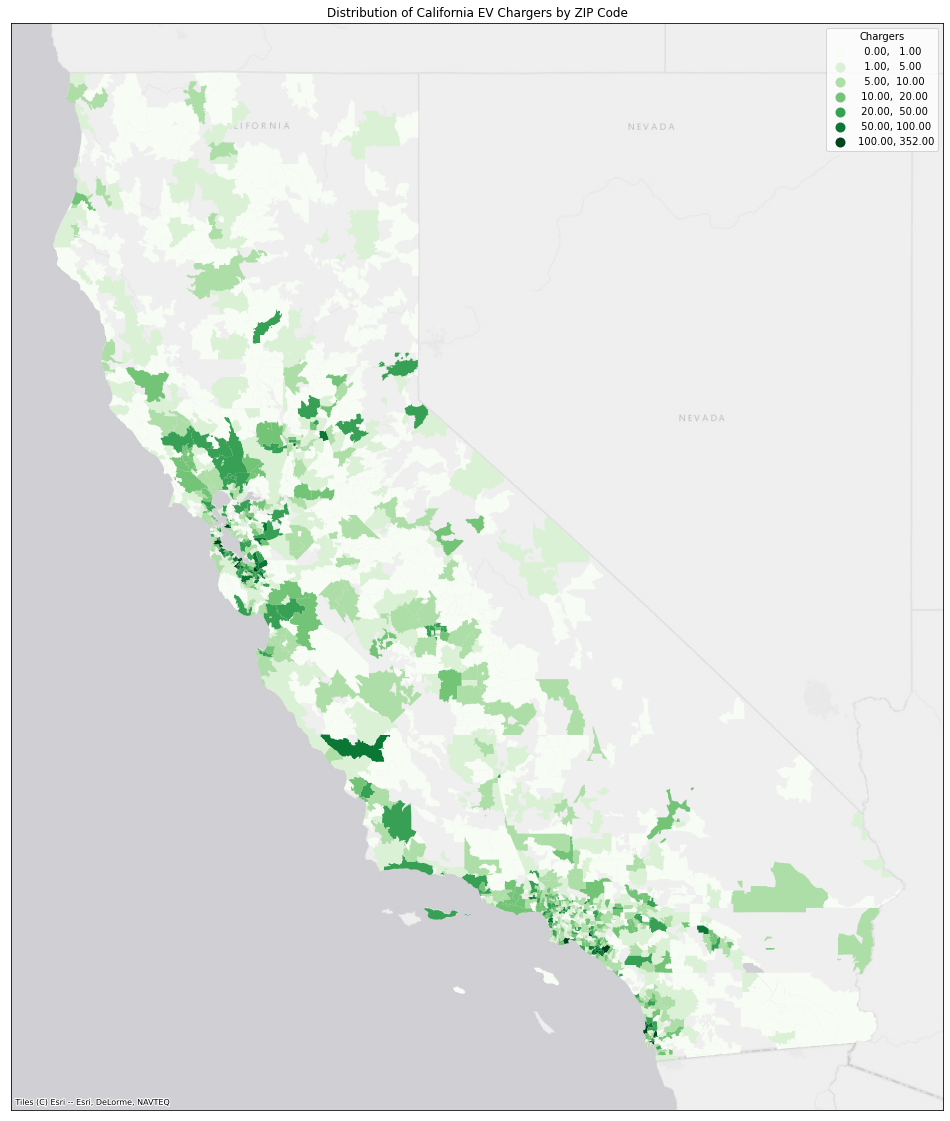

In [131]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize = (20,20))
df.to_crs("EPSG:3857").plot(ax = ax,column = "chargers", legend = True, scheme = 'User_Defined', classification_kwds=dict(bins = [1,5,10,20,50,100]), legend_kwds = {'title':'Chargers'}, cmap = "Greens")
ax.set(title = "Distribution of California EV Chargers by ZIP Code")
ax.set_xticks([])
ax.set_yticks([])
ctx.add_basemap(ax = ax,source = ctx.providers.Esri.WorldGrayCanvas)

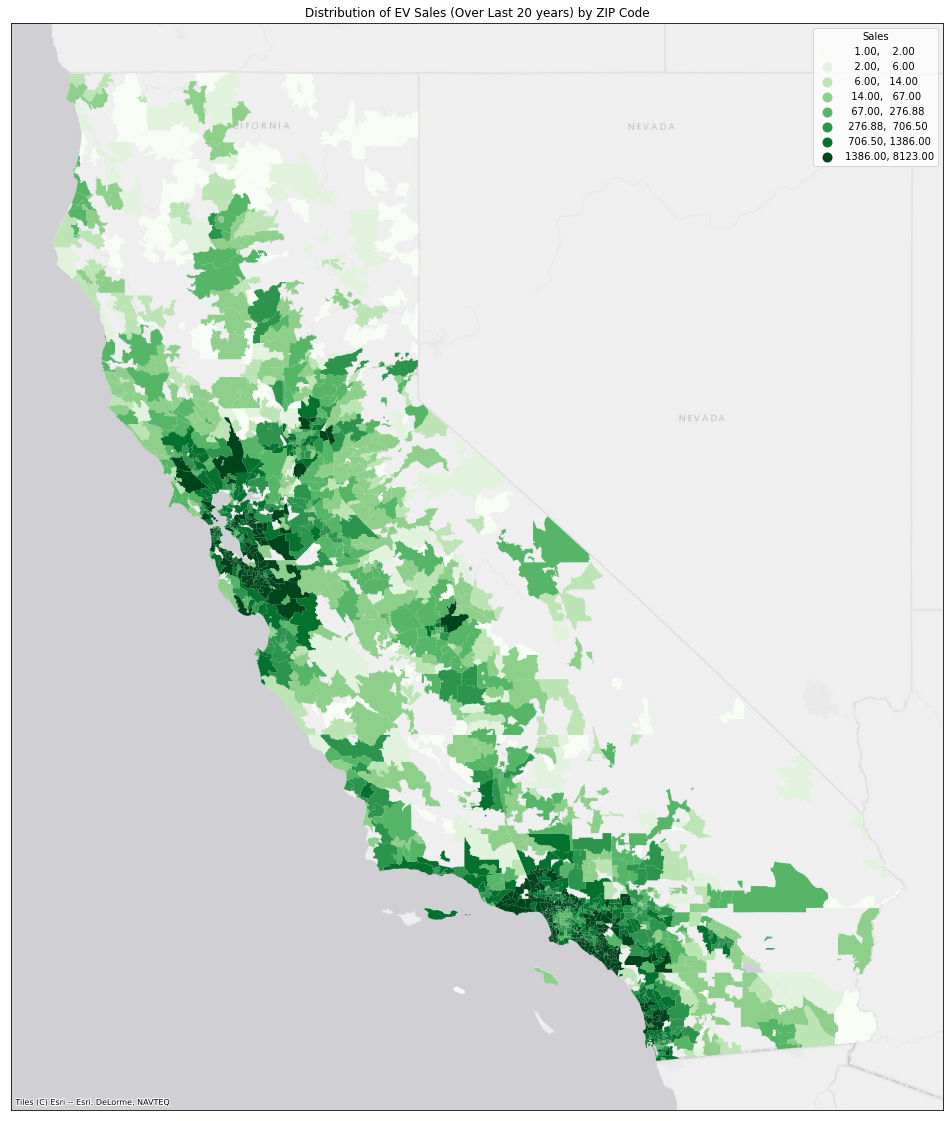

In [132]:
fig, ax = plt.subplots(figsize = (20,20))
df.to_crs("EPSG:3857").plot(ax = ax,column = "Number of Vehicles", legend = True, scheme = 'quantiles', k = 8, legend_kwds = {'title':'Sales'}, cmap = "Greens")
ax.set(title = "Distribution of EV Sales (Over Last 20 years) by ZIP Code")
ax.set_xticks([])
ax.set_yticks([])
ctx.add_basemap(ax = ax,source = ctx.providers.Esri.WorldGrayCanvas)

(Note: the zip codes where nobody lives (National/State Parks, National Forests, etc) show up as blank)

Okay, so both chargers and sales seem to be concentrated around major urban areas, specifically LA and the Bay Area (which isn't surprising). There does seem to be a LARGE amount of zip codes with zero chargers, which is a problem even though those areas do tend to be less densely populated; part of the battle of getting people to adopt EV's is ensuring that they'll be able to charge them anywhere they might find themselves, even in rural areas.

Now, let's look at the chargers per 1000 EV's category, as it will show us where the real mismatches exist between how many EV's a zipcode has and how many its charging infrastructure can support. Experts suggest one charger for around every 10-15 EV's (https://www.axios.com/2021/08/06/electric-vehicle-charging-stations-equity), which translates to 66-100 chargers per 1000 EV's. 

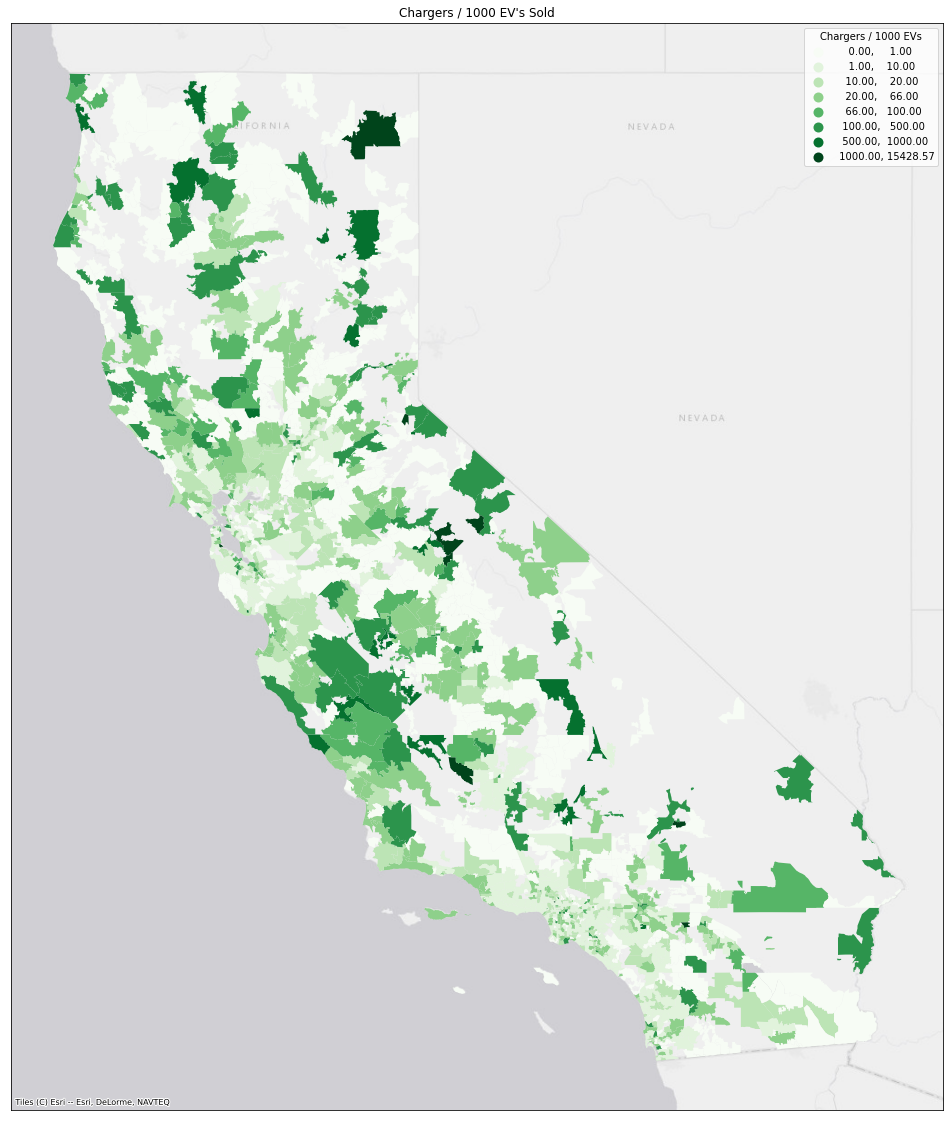

In [133]:
fig, ax = plt.subplots(figsize = (20,20))
df.to_crs("EPSG:3857").plot(ax = ax, column = "Chargers/EV", scheme = "User_Defined", legend = True,  classification_kwds=dict(bins = [1,10,20,66,100,500,1000]), legend_kwds = {"title":"Chargers / 1000 EVs"}, cmap = "Greens")
ax.set(title = "Chargers / 1000 EV's Sold")
ax.set_xticks([])
ax.set_yticks([])
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas)

Okay, so there's all kinds of variation, and it doesn't seem to be centered on urban areas like the other maps. Many rural areas have high values despite very low sales totals, probably resulting from charging infrastructure aimed at people driving through. Let's zoom in on more populated areas just to see what the data looks like without this phenomenon of rural outliers:

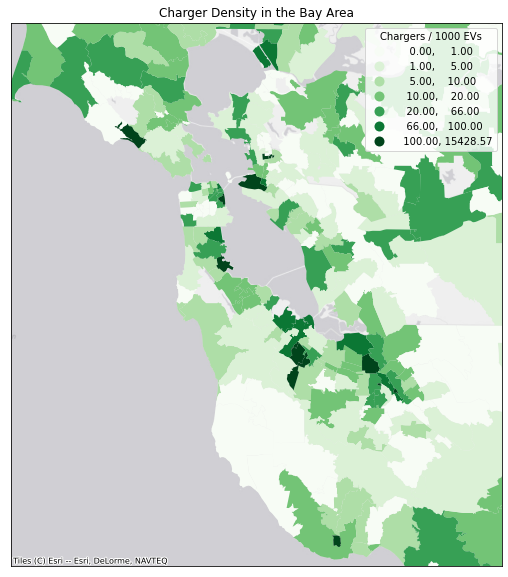

In [137]:
#zoom in on Bay Area
fig, ax = plt.subplots(figsize = (10,10))

#set bounding box
xlim = (-13691777.9143, -13534929.1322)
ylim = (4429751.5172,4603416.4455)
df.to_crs("EPSG:3857").plot(ax = ax, column = "Chargers/EV", scheme = "User_Defined", legend = True,  classification_kwds=dict(bins = [1,5,10,20,66,100]), legend_kwds = {"title":"Chargers / 1000 EVs"}, cmap = "Greens")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set(title = "Charger Density in the Bay Area")
ax.set_xticks([])
ax.set_yticks([])
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas)

Again, there's a decent amount of variation, but we can see a general trend of higher charger density in San Jose/San Francisco/Oakland and a lower amount of chargers per EV in the East Bay suburbs, many of which have less than 5 public chargers per 1000 EV's. 

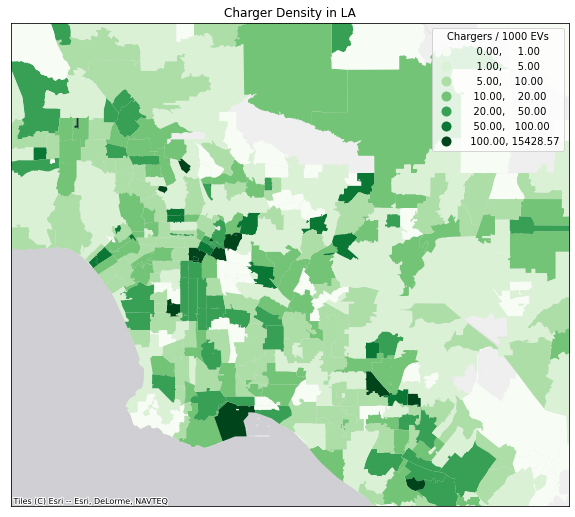

In [138]:
#zoom in on LA
#-13209235.7320,3975948.4633,-13083573.2575,4084794.7916
fig, ax = plt.subplots(figsize = (10,10))

xlim = (-13209235.7320, -13083573.2575)
ylim = (3975948.4633,4084794.7916)
df.to_crs("EPSG:3857").plot(ax = ax, column = "Chargers/EV", scheme = "User_Defined", legend = True,  classification_kwds=dict(bins = [1,5,10,20,50,100]), legend_kwds = {"title":"Chargers / 1000 EVs"}, cmap = "Greens")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set(title = "Charger Density in LA")
ax.set_xticks([])
ax.set_yticks([])
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas)

LA seems to have more public chargers per EV than much of the Bay Area, but much of East LA is relatively lacking, with under 10-20 chargers per 1000 EVs.

Finally, let's look at which zip codes are meeting the suggested minimum of public chargers available (15 EV's charger, or 66 chargers per 1000 EVs). This will give us a good idea of how much cities are lagging behind the total demand for EV's. 

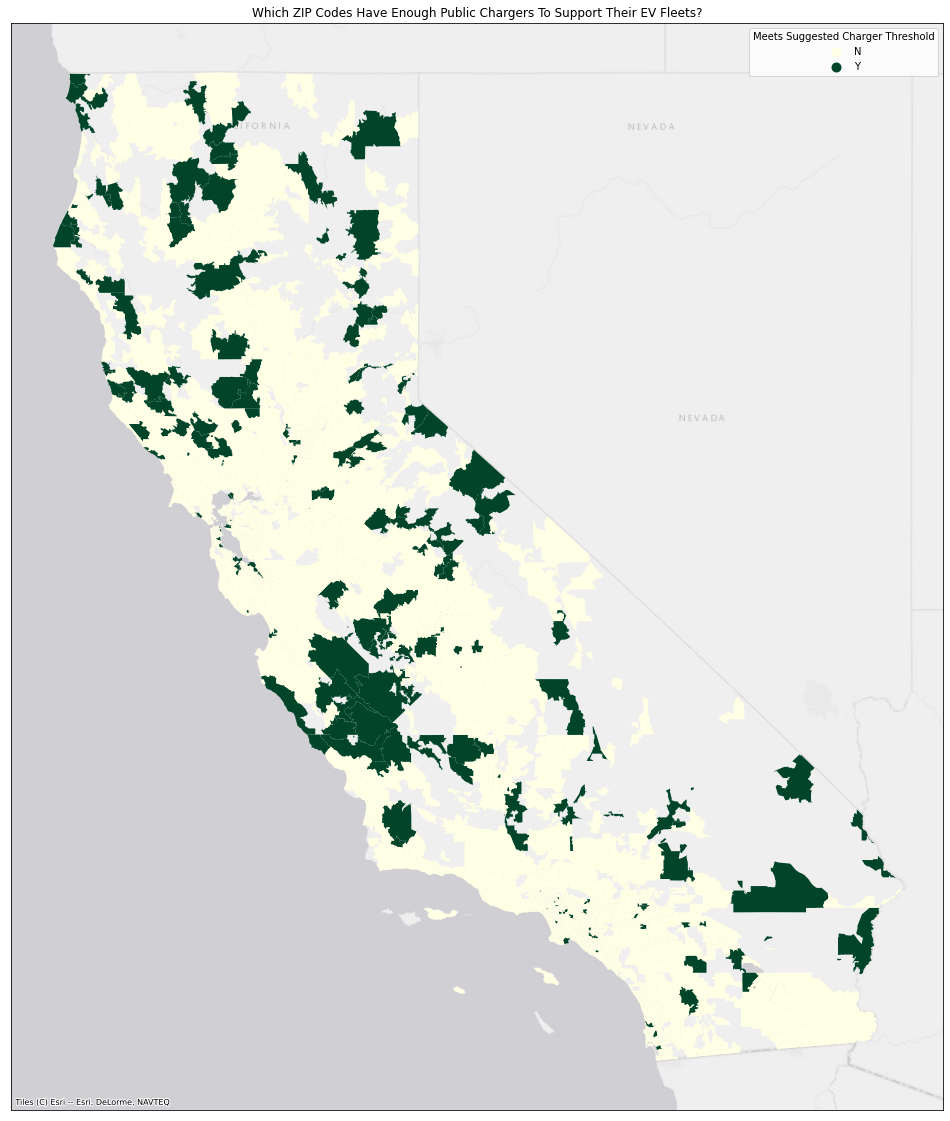

In [147]:
fig, ax = plt.subplots(figsize = (20,20))
df.to_crs("EPSG:3857").plot(ax = ax, column = "Chargers/EV", scheme = "User_Defined", legend = True,  classification_kwds=dict(bins = [66]), legend_kwds = {"title":"Meets Suggested Charger Threshold", "labels":'NY'}, cmap = "YlGn")
ax.set(title = "Which ZIP Codes Have Enough Public Chargers To Support Their EV Fleets?")
ax.set_xticks([])
ax.set_yticks([])
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas)

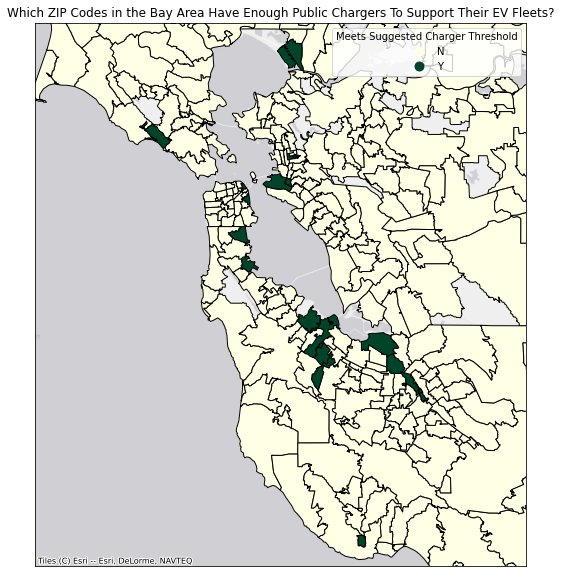

In [150]:
#zoom in on Bay Area
fig, ax = plt.subplots(figsize = (10,10))

#set bounding box
xlim = (-13691777.9143, -13534929.1322)
ylim = (4429751.5172,4603416.4455)
df.to_crs("EPSG:3857").plot(ax = ax, column = "Chargers/EV", scheme = "User_Defined", legend = True,  classification_kwds=dict(bins = [66]), legend_kwds = {"title":"Meets Suggested Charger Threshold", "labels":'NY'}, cmap ="YlGn", edgecolor = "black")
ax.set(title = "Which ZIP Codes in the Bay Area Have Enough Public Chargers To Support Their EV Fleets?")
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks([])
ax.set_yticks([])
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas)

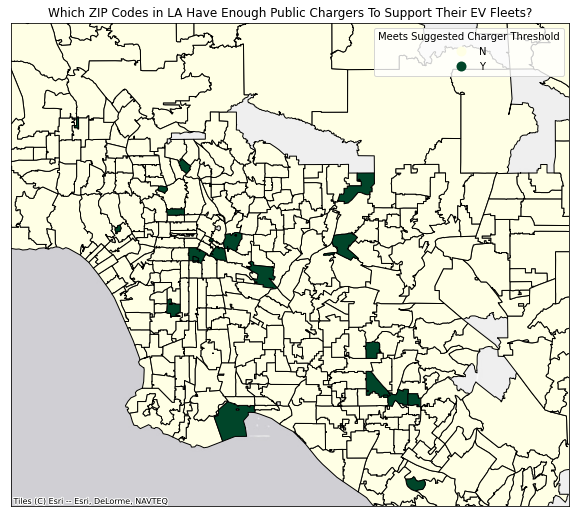

In [151]:
#zoom in on LA
#-13209235.7320,3975948.4633,-13083573.2575,4084794.7916
fig, ax = plt.subplots(figsize = (10,10))

xlim = (-13209235.7320, -13083573.2575)
ylim = (3975948.4633,4084794.7916)
df.to_crs("EPSG:3857").plot(ax = ax, column = "Chargers/EV", scheme = "User_Defined", legend = True,  classification_kwds=dict(bins = [66]), legend_kwds = {"title":"Meets Suggested Charger Threshold", "labels":'NY'}, cmap = "YlGn", edgecolor = "black")
ax.set(title = "Which ZIP Codes in LA Have Enough Public Chargers To Support Their EV Fleets?")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xticks([])
ax.set_yticks([])
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas)

Yikes. While there are some areas across the state that meet the threshold, they are mostly rural ZIP codes skewed by what are likely very small amounts of EV purchases. In both the Bay Area and LA, however, there are VERY few ZIP codes that meet the threshold. This suggests an overreliance on private chargers, which favors homeowners over less well-off residents and means that there's a huge need for greater public charging infrastructure in both urban areas.

Just for rererence, let's take a look at how EV sales have increased over the time period tracked by our data:

In [103]:
sales = pd.read_csv("data/ZEV_Sales_by_Zipcode.csv")
sales = sales[sales['Fuel Type'] == 'Electric']

In [104]:
sales_year = sales.groupby("Data Year").sum()['Number of Vehicles']

In [105]:
sales_year = pd.DataFrame(sales_year)

<AxesSubplot:xlabel='Data Year', ylabel='Number of Vehicles'>

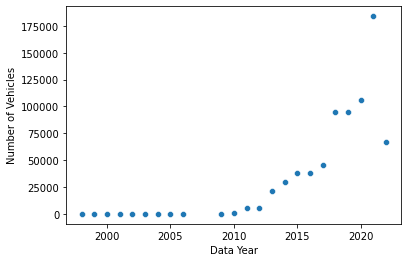

In [108]:
sns.scatterplot(data = sales_year, x = "Data Year", y = "Number of Vehicles")

And we can do a quick check of how many chargers have been built each year as well:

In [65]:
chargers = pd.read_pickle("data/chargers")


In [68]:
chargers_year = chargers.groupby('year').count()['access_code']

In [71]:
chargers_year = pd.DataFrame(chargers_year)
chargers_year.rename(columns = {"access_code":"chargers_built"}, inplace = True)

<AxesSubplot:xlabel='year', ylabel='chargers_built'>

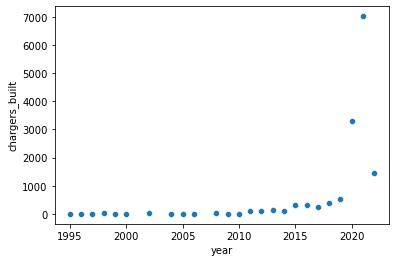

In [110]:
sns.scatterplot(data = chargers_year, x = "year", y = "chargers_built")

And now we can track chargers per EV by year! We'll keep it in the same chargers per 1000 EV's units, just for continuity's sake:

In [90]:
chargers_year.index = pd.to_numeric(chargers_year.index)

In [92]:
chargers_year['density'] = 1000*(chargers_year['chargers_built']/sales_year['Number of Vehicles'])
chargers_year

,chargers_built,density
year,,
1995,1,NaN
1996,1,NaN
1997,7,NaN
1998,16,3200.000000
1999,1,1000.000000
2000,3,1500.000000
2002,18,6000.000000
2004,13,13000.000000
2005,3,375.000000


Okay, there seem to be some pretty massibe outliers before 2009, so let's just keep the data after then:

In [96]:
density_year = chargers_year[chargers_year.index > 2009]

In [116]:
density_year.index

Int64Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
            2021, 2022],
           dtype='int64', name='year')

<AxesSubplot:xlabel='year', ylabel='density'>

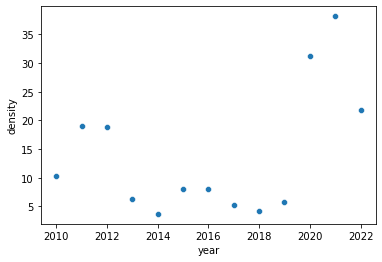

In [123]:
sns.scatterplot(data = density_year, x = "year", y = "density")

Okay, so the density is also a bit all over the place (but seems to be trending upwards recently!); however, it should be noted that even in the highest density year (2021), it's barely more than half the suggested value of 66. 

# Final Takeaways

What have we learned overall?

* Both charging stations and overall EV sales are clustered around the state's major urban areas
* "Charger Density" (the number of chargers per 1000 EVs) varies wildly; there are many ZIP codes with zero chargers whatsoever, and some rural areas have huge charger densities on paper due to the very small amount of EVs sold there. In larger cities, the number tends to be between 5-50 chargers per 1000 EVs.
* The suggested minumum amount of chargers per 1000 EVs is around 66; even in large urban areas like SF and LA, very few ZIP codes meet this threshold. This means that the (public) EV charging network isn't even large enough to meet the real demand of the current EV fleet (forcing them to rely more on private chargers than is ideal), to say nothing about the future fleet. 
* If we look at year-by-year data, EV sales have steadily increased since around 2010, while charger construction only started to pick up around 2015 before skyrocketing in 2020 and 2021. Charger density has fluctuated throughout the last decade, reaching a peak in 2020 and 2021; however, even these years were still only around half the ideal minimum density of 66 charger per 1000 EVs.
